# Omission LFP Analysis

Brief 1-2 sentence description of notebook.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import glob
from collections import defaultdict
import re

In [3]:
# Imports of all used packages and libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from scipy import stats
import itertools

In [4]:
import spikeinterface.extractors as se
import spikeinterface.preprocessing as sp
from spectral_connectivity import Multitaper, Connectivity
import spectral_connectivity

## Inputs & Data

Explanation of each input and where it comes from.

In [5]:
# Inputs and Required data loading
# input varaible names are in all caps snake case
# Whenever an input changes or is used for processing 
# the vairables are all lower in snake case

In [6]:
BBOX_TO_ANCHOR=(1.5, 0.9)
LOC='upper right'

In [7]:
# variables for LFP extraction
FREQ_MIN=0.5
FREQ_MAX=300
FREQ=60
RESAMPLE_RATE=1000
TRIAL_DURATION=10

In [8]:
INPUT_VARIABLE = 1

TIME_HALFBANDWIDTH_PRODUCT = 2
TIME_WINDOW_DURATION = 3
TIME_WINDOW_STEP = 1.5 

TRIAL_TIME_STAMP_DURATION = 1000*10

In [9]:
BIN_TO_COLOR = {0: {"baseline": "lightblue", "trial": "blue"}, 1: {"baseline": "lightgreen", "trial": "green"}, 2: {"baseline": "lightcoral", "trial": "red"}}
TRIAL_OR_BASELINE_TO_STYLE = {'baseline': "--", "trial": "-"}
BIN_TO_VELOCITY = {0: "0 to 2.5cm/s", 1: "2.5 to 5cm/s", 2: "5cm/s+"}

In [10]:
NUM_LINES = 3

In [11]:
# Generate colors from the "Blues" colormap
LOSING_COLORS = cm.Oranges(np.linspace(0.5, 1, NUM_LINES))
# Generate colors from the "Blues" colormap
WINNING_COLORS = cm.Blues(np.linspace(0.5, 1, NUM_LINES))
# Generate colors from the "Blues" colormap
REWARDED_COLORS = cm.Greens(np.linspace(0.5, 1, NUM_LINES))
# Generate colors from the "Blues" colormap
OMISSION_COLORS = cm.Reds(np.linspace(0.5, 1, NUM_LINES))

In [12]:
BASELINE_OUTCOME_TO_COLOR = {'lose': "orange",
'lose_baseline': LOSING_COLORS[0],
'omission': "red",
'omission_baseline': "hotpink",
'rewarded': "green",
'rewarded_baseline': REWARDED_COLORS[0],
'win': "blue",
'win_baseline': WINNING_COLORS[0],
'lose_comp': "orange", 
'lose_non_comp': "yellow",
'win_comp': "blue", 
'win_non_comp': WINNING_COLORS[0]}

In [13]:
COMPETITIVE_OUTCOME_TO_COLOR = {'lose_comp': "orange", 
'lose_non_comp': "yellow",
'omission': "red",
'rewarded': "green",
'win_comp': "blue", 
'win_non_comp': WINNING_COLORS[0]}

In [14]:
TRIAL_OR_BASELINE_TO_STYLE = {'baseline': "--", "trial": "-"}

In [15]:
CHANNEL_MAPPING_DF = pd.read_excel("../../channel_mapping.xlsx")
CHANNEL_MAPPING_DF["Subject"] = CHANNEL_MAPPING_DF["Subject"].astype(str)

TONE_TIMESTAMP_DF = pd.read_excel("../../rce_tone_timestamp.xlsx", index_col=0)
OUTPUT_DIR = r"./proc" # where data is saved should always be shown in the inputs


In [16]:
FULL_LFP_TRACES = pd.read_pickle("./proc/full_baseline_and_trial_lfp_traces.pkl")

In [17]:
FULL_LFP_TRACES = FULL_LFP_TRACES.drop_duplicates(subset=["recording_file", "time"], keep="first")

In [18]:
from scipy import signal

TIME_HALFBANDWIDTH_PRODUCT = 3
TIME_WINDOW_DURATION = 1.0  # in seconds, adjust based on your data
TIME_WINDOW_STEP = 0.5  # in seconds, adjust based on your data

In [19]:
GROUPINGS = "competition_closeness"


## Outputs

Describe each output that the notebook creates. 

- Is it a plot or is it data?

- How valuable is the output and why is it valuable or useful?

## Functions

- Ideally functions are defined here first and then data is processed using the functions
    - function names are short and in snake case all lowercase
    - a function name should be unique but does not have to describe the function
    - doc strings describe functions not function names

In [20]:
def generate_pairs(lst):
    pairs = []
    n = len(lst)
    for i in range(n):
        for j in range(i+1, n):
            pairs.append((lst[i], lst[j]))
    return pairs

## Processing

Describe what is done to the data here and how inputs are manipulated to generate outputs. 

In [21]:
# As much code and as many cells as required
# includes EDA and playing with data
# GO HAM!

## Coherece Calculation

In [22]:
trial_trace_columns = sorted([col for col in FULL_LFP_TRACES.columns if "trial_lfp_trace" in col])
baseline_trace_columns = sorted([col for col in FULL_LFP_TRACES.columns if "baseline_lfp_trace" in col])

In [23]:
trial_trace_columns

['BLA_trial_lfp_trace',
 'LH_trial_lfp_trace',
 'MD_trial_lfp_trace',
 'mPFC_trial_lfp_trace',
 'vHPC_trial_lfp_trace']

In [24]:
trial_brain_region_pairs = generate_pairs(trial_trace_columns)
trial_brain_region_pairs = sorted(trial_brain_region_pairs)
baseline_brain_region_pairs = generate_pairs(baseline_trace_columns)
baseline_brain_region_pairs = sorted(baseline_brain_region_pairs)

In [25]:
trial_brain_region_pairs

[('BLA_trial_lfp_trace', 'LH_trial_lfp_trace'),
 ('BLA_trial_lfp_trace', 'MD_trial_lfp_trace'),
 ('BLA_trial_lfp_trace', 'mPFC_trial_lfp_trace'),
 ('BLA_trial_lfp_trace', 'vHPC_trial_lfp_trace'),
 ('LH_trial_lfp_trace', 'MD_trial_lfp_trace'),
 ('LH_trial_lfp_trace', 'mPFC_trial_lfp_trace'),
 ('LH_trial_lfp_trace', 'vHPC_trial_lfp_trace'),
 ('MD_trial_lfp_trace', 'mPFC_trial_lfp_trace'),
 ('MD_trial_lfp_trace', 'vHPC_trial_lfp_trace'),
 ('mPFC_trial_lfp_trace', 'vHPC_trial_lfp_trace')]

In [26]:
baseline_brain_region_pairs

[('BLA_baseline_lfp_trace', 'LH_baseline_lfp_trace'),
 ('BLA_baseline_lfp_trace', 'MD_baseline_lfp_trace'),
 ('BLA_baseline_lfp_trace', 'mPFC_baseline_lfp_trace'),
 ('BLA_baseline_lfp_trace', 'vHPC_baseline_lfp_trace'),
 ('LH_baseline_lfp_trace', 'MD_baseline_lfp_trace'),
 ('LH_baseline_lfp_trace', 'mPFC_baseline_lfp_trace'),
 ('LH_baseline_lfp_trace', 'vHPC_baseline_lfp_trace'),
 ('MD_baseline_lfp_trace', 'mPFC_baseline_lfp_trace'),
 ('MD_baseline_lfp_trace', 'vHPC_baseline_lfp_trace'),
 ('mPFC_baseline_lfp_trace', 'vHPC_baseline_lfp_trace')]

In [27]:
"time_window_step".upper()

'TIME_WINDOW_STEP'

In [28]:
for region_1, region_2 in trial_brain_region_pairs:
    pair_base_name = "{}_{}".format(region_1.split("_")[0], region_2.split("_")[0])
    print(pair_base_name)
    try:
        multitaper_col = "{}_trial_multitaper".format(pair_base_name)
        FULL_LFP_TRACES[multitaper_col] = FULL_LFP_TRACES.apply(lambda x: Multitaper(time_series=np.array([x[region_1],x[region_2]]).T, sampling_frequency=RESAMPLE_RATE, time_halfbandwidth_product=TIME_HALFBANDWIDTH_PRODUCT, time_window_step=TIME_WINDOW_STEP, time_window_duration=TIME_WINDOW_DURATION), axis=1)
    
        connectivity_col = "{}_trial_connectivity".format(pair_base_name)
        FULL_LFP_TRACES[connectivity_col] = FULL_LFP_TRACES[multitaper_col].apply(lambda x: Connectivity.from_multitaper(x))
        
        FULL_LFP_TRACES["{}_trial_frequencies".format(pair_base_name)] = FULL_LFP_TRACES[connectivity_col].apply(lambda x: x.frequencies)
    
        FULL_LFP_TRACES["{}_trial_coherence_magnitude".format(pair_base_name)] = FULL_LFP_TRACES[connectivity_col].apply(lambda x: x.coherence_magnitude()[0, :, 0, 1])
    
    except Exception as e: 
        print(e)

BLA_LH
BLA_MD
BLA_mPFC
BLA_vHPC
LH_MD
LH_mPFC
LH_vHPC
MD_mPFC
MD_vHPC
mPFC_vHPC


In [29]:
for region_1, region_2 in baseline_brain_region_pairs:
    pair_base_name = "{}_{}".format(region_1.split("_")[0], region_2.split("_")[0])
    print(pair_base_name)
    try:
        multitaper_col = "{}_baseline_multitaper".format(pair_base_name)
        FULL_LFP_TRACES[multitaper_col] = FULL_LFP_TRACES.apply(lambda x: Multitaper(time_series=np.array([x[region_1],x[region_2]]).T, sampling_frequency=RESAMPLE_RATE, time_halfbandwidth_product=TIME_HALFBANDWIDTH_PRODUCT, time_window_step=TIME_WINDOW_STEP, time_window_duration=TIME_WINDOW_DURATION), axis=1)
    
        connectivity_col = "{}_baseline_connectivity".format(pair_base_name)
        FULL_LFP_TRACES[connectivity_col] = FULL_LFP_TRACES[multitaper_col].apply(lambda x: Connectivity.from_multitaper(x))
        
        FULL_LFP_TRACES["{}_baseline_frequencies".format(pair_base_name)] = FULL_LFP_TRACES[connectivity_col].apply(lambda x: x.frequencies)
    
        FULL_LFP_TRACES["{}_baseline_coherence_magnitude".format(pair_base_name)] = FULL_LFP_TRACES[connectivity_col].apply(lambda x: x.coherence_magnitude()[0, :, 0, 1])
    
    except Exception as e: 
        print(e)

BLA_LH
BLA_MD
BLA_mPFC
BLA_vHPC
LH_MD
LH_mPFC
LH_vHPC
MD_mPFC
MD_vHPC
mPFC_vHPC


In [30]:
all_pair_base_name = []
for region_1, region_2 in baseline_brain_region_pairs:
    all_pair_base_name.append("{}_{}".format(region_1.split("_")[0], region_2.split("_")[0]))
all_pair_base_name = sorted(all_pair_base_name)

In [31]:
all_pair_base_name

['BLA_LH',
 'BLA_MD',
 'BLA_mPFC',
 'BLA_vHPC',
 'LH_MD',
 'LH_mPFC',
 'LH_vHPC',
 'MD_mPFC',
 'MD_vHPC',
 'mPFC_vHPC']

In [32]:
low_freq = 0
high_freq = 100

In [33]:
FULL_LFP_TRACES["BLA_LH_baseline_coherence_magnitude"]

0      [0.7031018159609819, 0.7651205923341607, 0.632...
1      [0.7377486235276958, 0.8008115056915789, 0.844...
2      [0.722576391955291, 0.6524326230221966, 0.6268...
3      [0.904525908144622, 0.9686937463943575, 0.9142...
4      [0.6072285516158872, 0.8479921306101244, 0.842...
                             ...                        
406    [0.7232560769233622, 0.5849440612893951, 0.664...
407    [0.36854147435510964, 0.41084523897831193, 0.3...
408    [0.3143473528787948, 0.3579612205182576, 0.514...
409    [0.11678687990544956, 0.23257684916154714, 0.3...
410    [0.030184057154947125, 0.014320980811671739, 0...
Name: BLA_LH_baseline_coherence_magnitude, Length: 259, dtype: object

In [34]:
all_frequencies = FULL_LFP_TRACES["BLA_LH_baseline_frequencies"].iloc[0]

In [35]:
TRIAL_AND_BASELINE = ["trial", "baseline"]

In [36]:
FULL_LFP_TRACES["competition_closeness"]

0          lose_comp
1           win_comp
2           win_comp
3      lose_non_comp
4       win_non_comp
           ...      
406         rewarded
407         rewarded
408         rewarded
409         omission
410         rewarded
Name: competition_closeness, Length: 259, dtype: object

BLA_LH


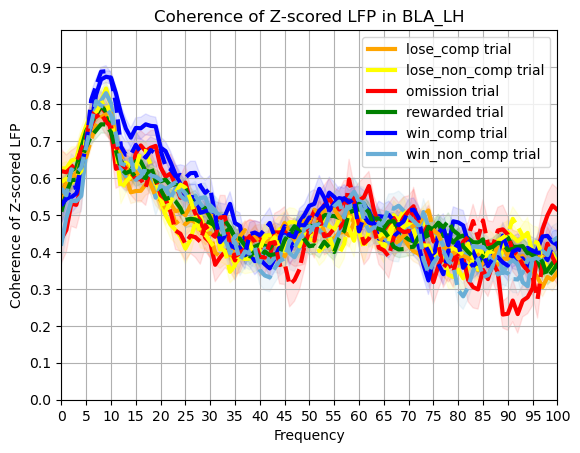

BLA_MD


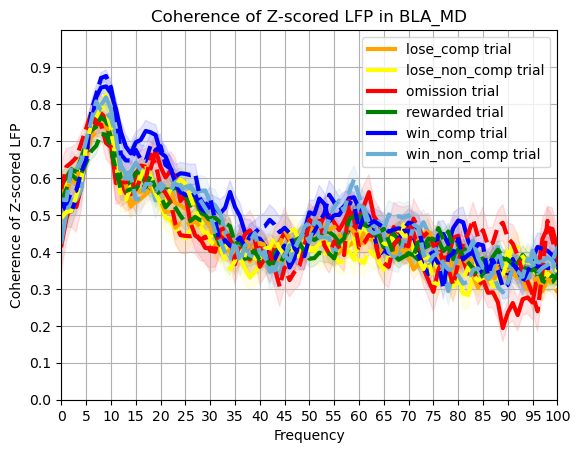

BLA_mPFC


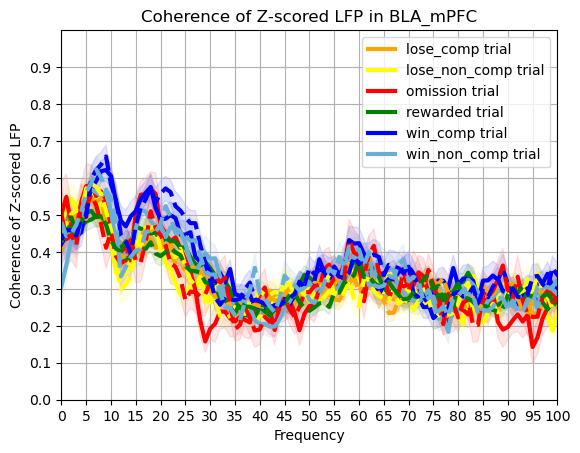

BLA_vHPC


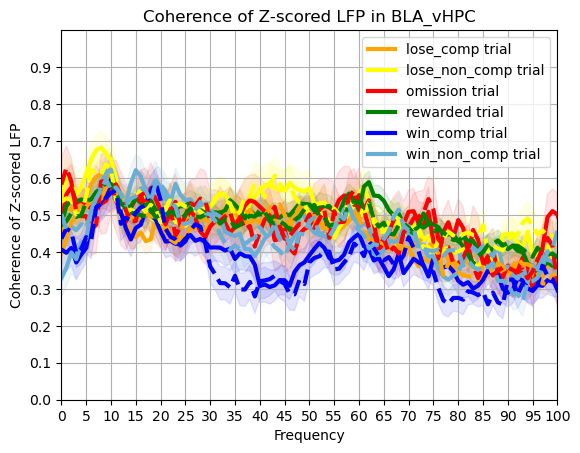

LH_MD


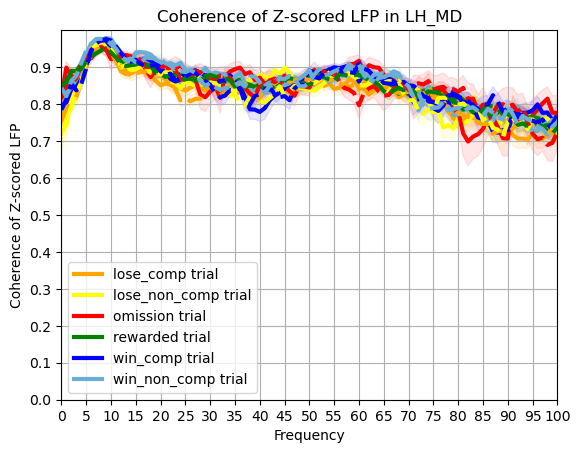

LH_mPFC


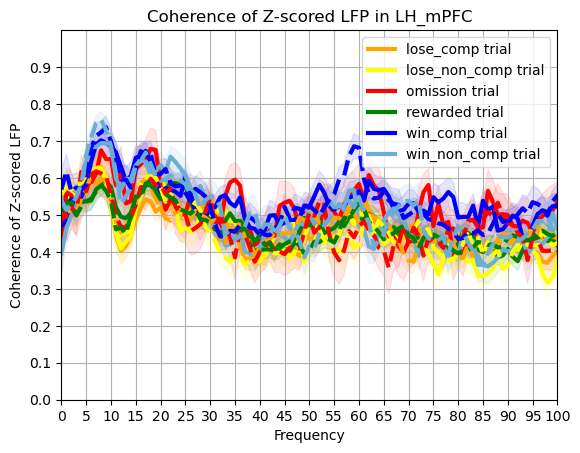

LH_vHPC


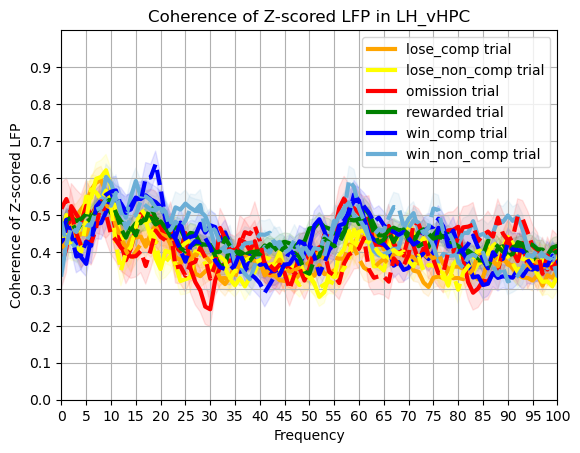

MD_mPFC


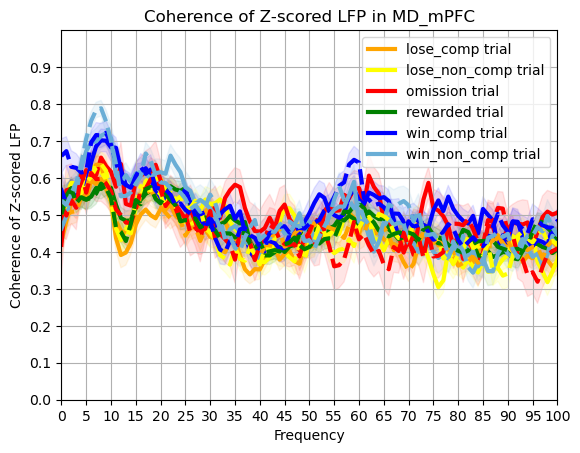

MD_vHPC


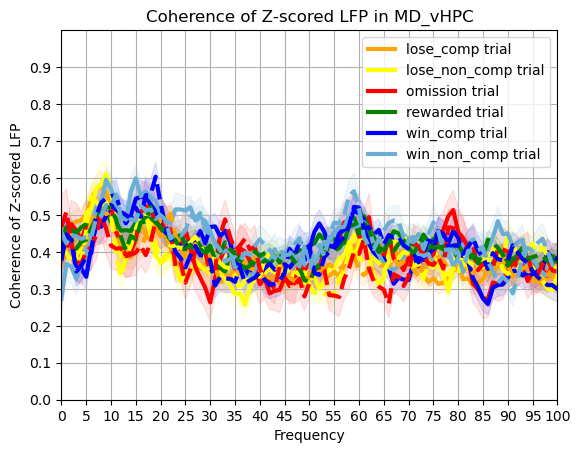

mPFC_vHPC


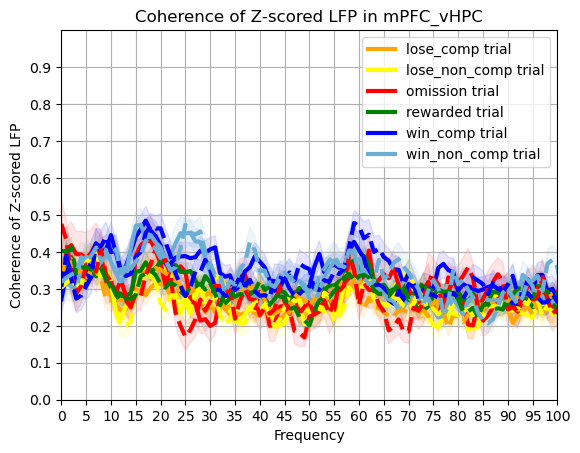

In [37]:
for pair_base_name in all_pair_base_name:
    print(pair_base_name)
    
    fig, ax = plt.subplots()
    plt.title("Coherence of Z-scored LFP in {}".format(pair_base_name))
    plt.xlabel("Frequency")
    plt.ylabel("Coherence of Z-scored LFP")
    plt.xlim(low_freq, high_freq)
    plt.xticks(np.arange(low_freq, high_freq+1, 5))
    plt.yticks(np.arange(0, 1, 0.1))
    plt.ylim(0,1)
    plt.grid()

    for trial_or_baseline in TRIAL_AND_BASELINE:

        coherence_col = "{}_{}_coherence_magnitude".format(pair_base_name, trial_or_baseline)
        grouped_all_trials_df = FULL_LFP_TRACES.groupby([GROUPINGS]).agg({coherence_col: lambda x: np.vstack(x.tolist())}).reset_index()
        # grouped_all_trials_df = grouped_all_trials_df[grouped_all_trials_df["trial_or_baseline"] == "trial"]
        grouped_all_trials_df["mean_coherence"] = grouped_all_trials_df[coherence_col].apply(lambda x: np.nanmean(np.vstack(x), axis=0))
        grouped_all_trials_df["std_coherence"] = grouped_all_trials_df[coherence_col].apply(lambda x: np.nanstd(np.vstack(x), axis=0))
        grouped_all_trials_df["n_trials"] = grouped_all_trials_df[coherence_col].apply(lambda x: np.sum(~np.isnan(x), axis=0))
        grouped_all_trials_df["sem_coherence"] = grouped_all_trials_df.apply(lambda x: x["std_coherence"] / np.sqrt(x["n_trials"]), axis=1)
        for index, row in grouped_all_trials_df.iterrows():
            try:
                if trial_or_baseline == "trial":
                    ax = sns.lineplot(x=all_frequencies, y=row["mean_coherence"], \
                label="{} {}".format(row[GROUPINGS], trial_or_baseline), color=BASELINE_OUTCOME_TO_COLOR[row[GROUPINGS]],
                linestyle=TRIAL_OR_BASELINE_TO_STYLE[trial_or_baseline], linewidth=3)
                else:
                    ax = sns.lineplot(x=all_frequencies, y=row["mean_coherence"], \
                color=BASELINE_OUTCOME_TO_COLOR[row[GROUPINGS]],
                linestyle=TRIAL_OR_BASELINE_TO_STYLE[trial_or_baseline], linewidth=3)
                

    
                plt.fill_between(all_frequencies, \
                row["mean_coherence"] - row["sem_coherence"], row["mean_coherence"] + row["sem_coherence"], alpha=0.1,
                color=BASELINE_OUTCOME_TO_COLOR[row[GROUPINGS]])
            except Exception as e: 
                print(e)


    
    # plt.savefig("./proc/coherence/{}_coherence_of_zscored_lfp.png".format(pair_base_name))
    plt.show()
    
    
    

    

BLA_LH


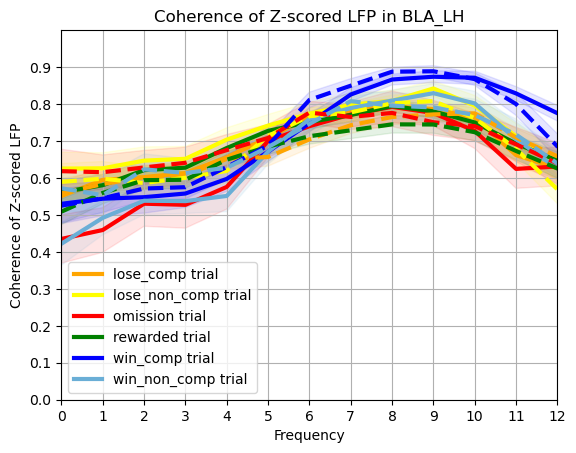

BLA_MD


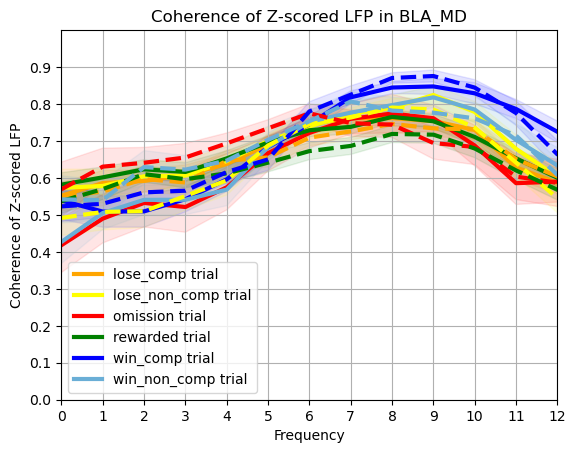

BLA_mPFC


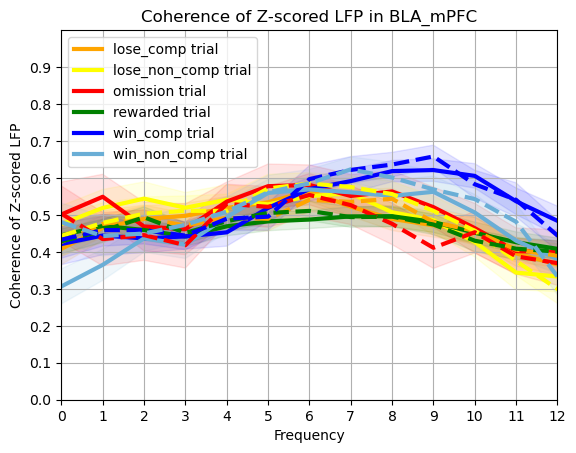

BLA_vHPC


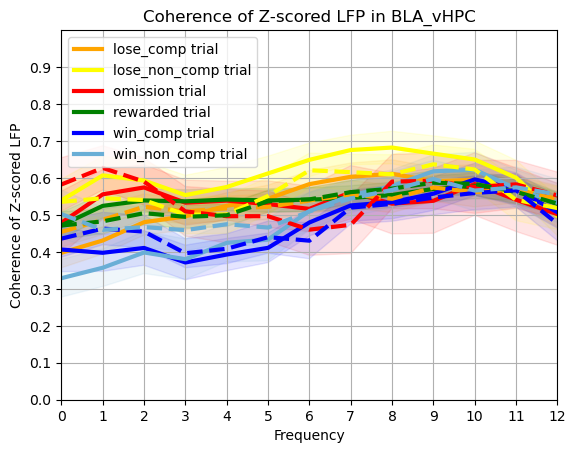

LH_MD


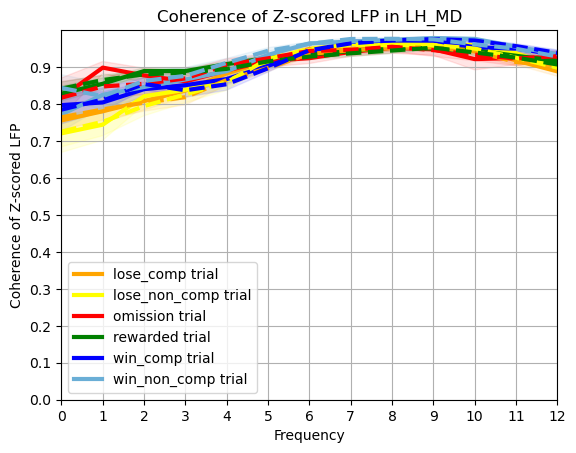

LH_mPFC


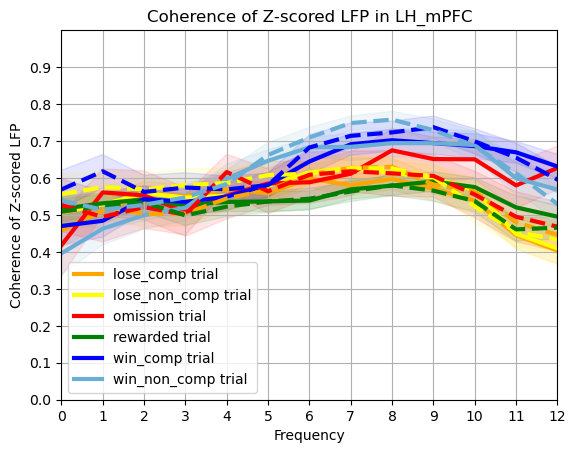

LH_vHPC


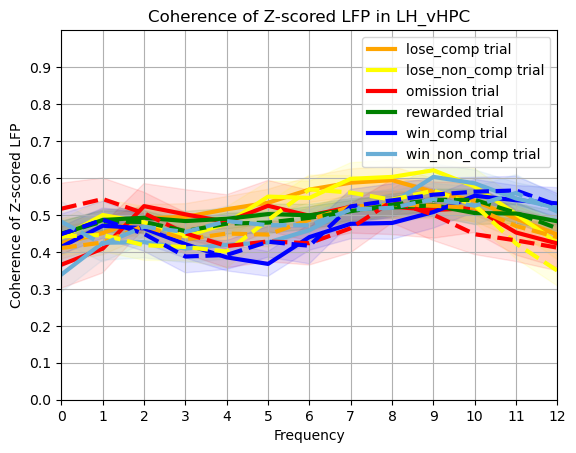

MD_mPFC


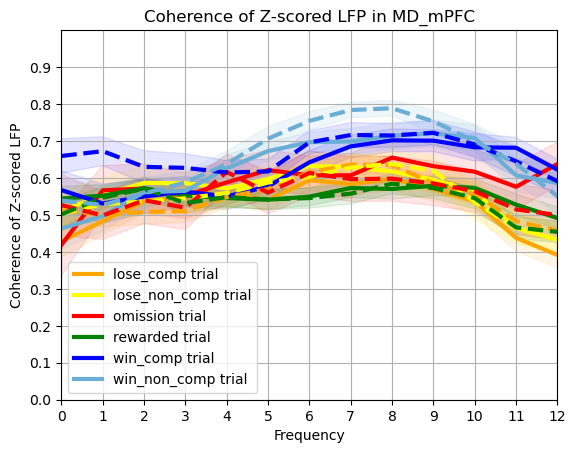

MD_vHPC


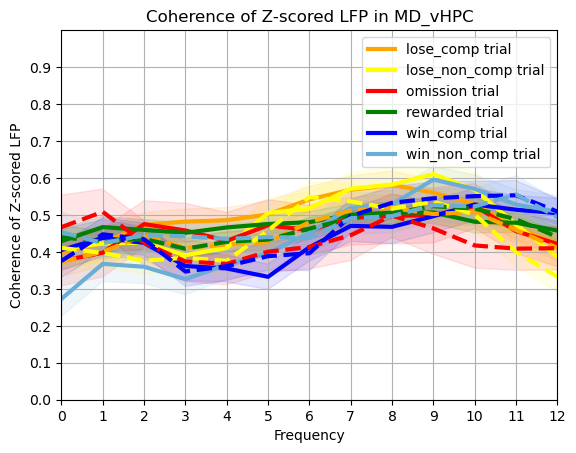

mPFC_vHPC


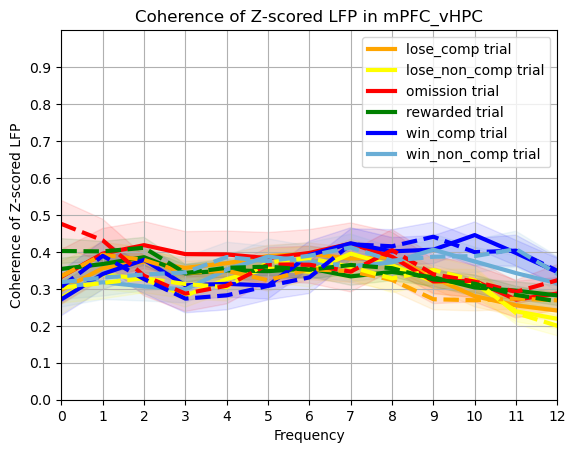

In [38]:
low_freq = 0
high_freq = 12
for pair_base_name in all_pair_base_name:
    print(pair_base_name)
    
    fig, ax = plt.subplots()
    plt.title("Coherence of Z-scored LFP in {}".format(pair_base_name))
    plt.xlabel("Frequency")
    plt.ylabel("Coherence of Z-scored LFP")
    plt.xlim(low_freq, high_freq)
    plt.xticks(np.arange(low_freq, high_freq+1, 1))
    plt.yticks(np.arange(0, 1, 0.1))
    plt.ylim(0,1)
    plt.grid()

    for trial_or_baseline in TRIAL_AND_BASELINE:

        coherence_col = "{}_{}_coherence_magnitude".format(pair_base_name, trial_or_baseline)
        grouped_all_trials_df = FULL_LFP_TRACES.groupby([GROUPINGS]).agg({coherence_col: lambda x: np.vstack(x.tolist())}).reset_index()
        # grouped_all_trials_df = grouped_all_trials_df[grouped_all_trials_df["trial_or_baseline"] == "trial"]
        grouped_all_trials_df["mean_coherence"] = grouped_all_trials_df[coherence_col].apply(lambda x: np.nanmean(np.vstack(x), axis=0))
        grouped_all_trials_df["std_coherence"] = grouped_all_trials_df[coherence_col].apply(lambda x: np.nanstd(np.vstack(x), axis=0))
        grouped_all_trials_df["n_trials"] = grouped_all_trials_df[coherence_col].apply(lambda x: np.sum(~np.isnan(x), axis=0))
        grouped_all_trials_df["sem_coherence"] = grouped_all_trials_df.apply(lambda x: x["std_coherence"] / np.sqrt(x["n_trials"]), axis=1)
        for index, row in grouped_all_trials_df.iterrows():
            try:
                if trial_or_baseline == "trial":
                    ax = sns.lineplot(x=all_frequencies, y=row["mean_coherence"], \
                label="{} {}".format(row[GROUPINGS], trial_or_baseline), color=BASELINE_OUTCOME_TO_COLOR[row[GROUPINGS]],
                linestyle=TRIAL_OR_BASELINE_TO_STYLE[trial_or_baseline], linewidth=3)
                else:
                    ax = sns.lineplot(x=all_frequencies, y=row["mean_coherence"], \
                color=BASELINE_OUTCOME_TO_COLOR[row[GROUPINGS]],
                linestyle=TRIAL_OR_BASELINE_TO_STYLE[trial_or_baseline], linewidth=3)
                

    
                plt.fill_between(all_frequencies, \
                row["mean_coherence"] - row["sem_coherence"], row["mean_coherence"] + row["sem_coherence"], alpha=0.1,
                color=BASELINE_OUTCOME_TO_COLOR[row[GROUPINGS]])
            except Exception as e: 
                print(e)


    
    # plt.savefig("./proc/coherence/{}_coherence_of_zscored_lfp.png".format(pair_base_name))
    plt.show()
    
    
    

    

BLA_LH


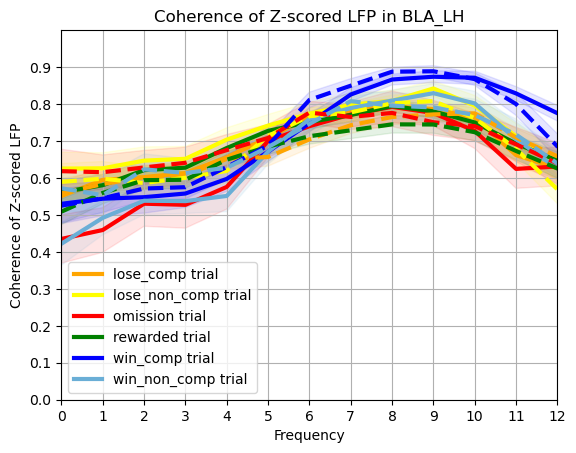

BLA_MD


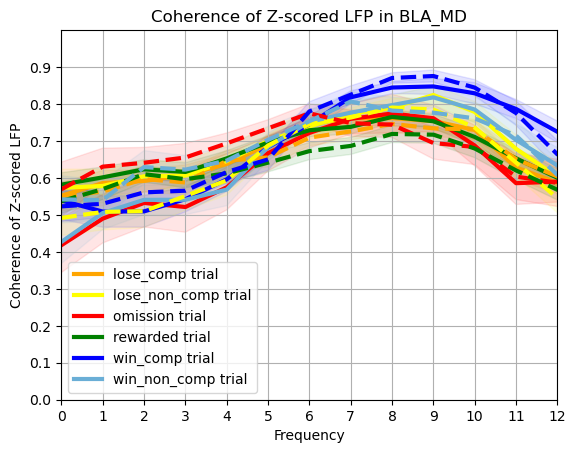

BLA_mPFC


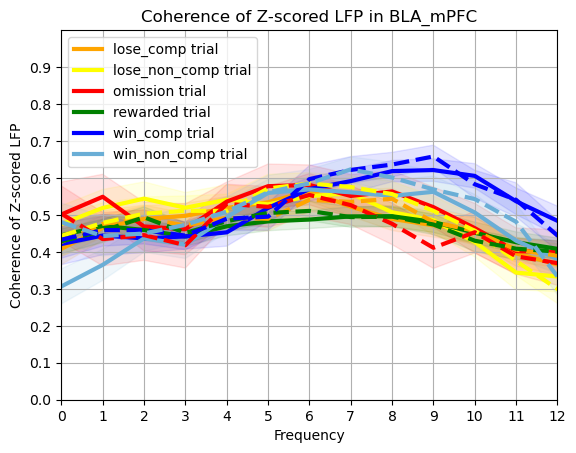

BLA_vHPC


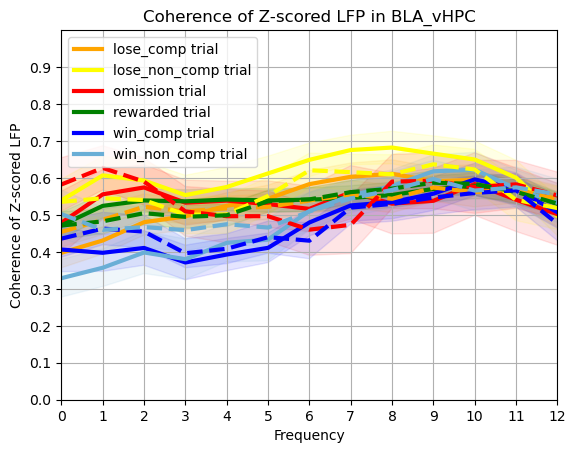

LH_MD


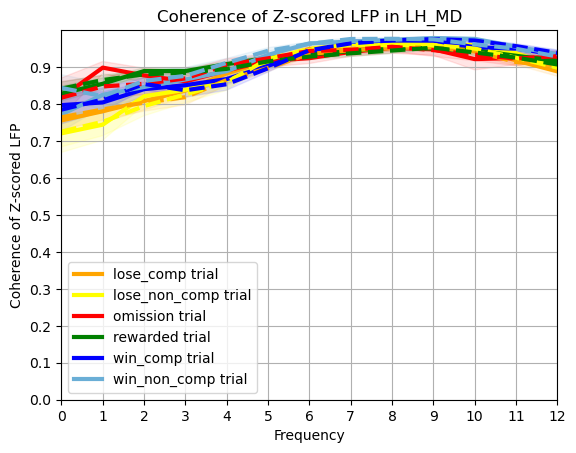

LH_mPFC


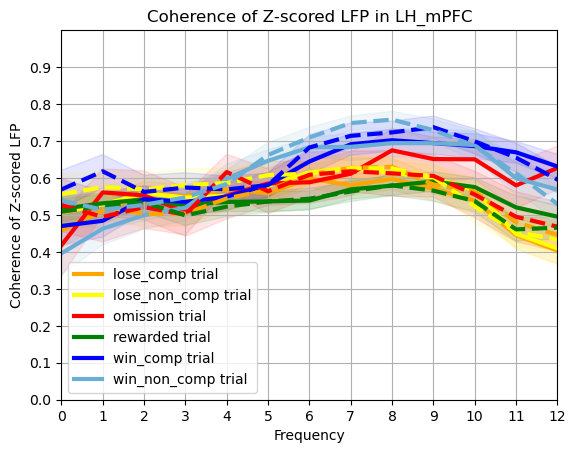

LH_vHPC


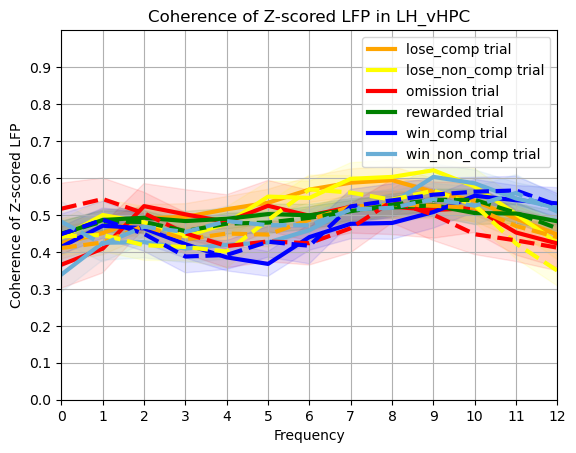

MD_mPFC


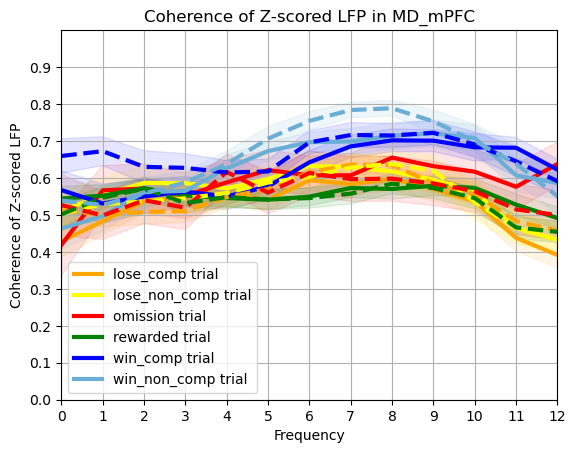

MD_vHPC


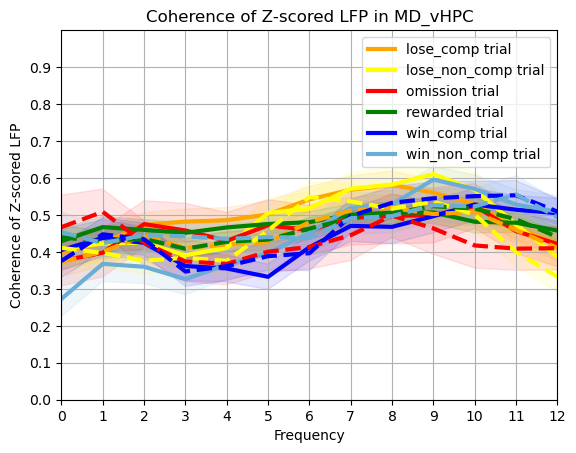

mPFC_vHPC


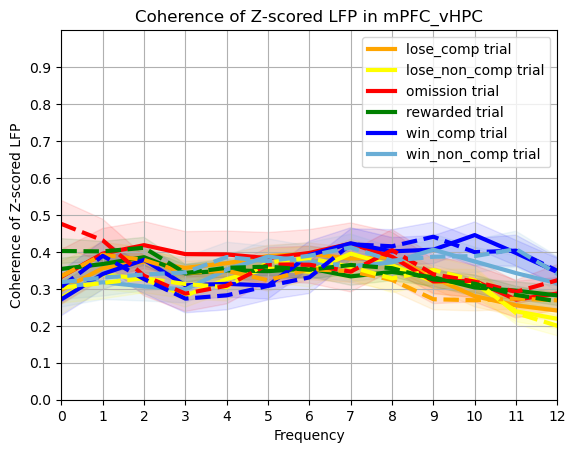

In [39]:
low_freq = 10
high_freq = 30
low_freq = 0
high_freq = 12
for pair_base_name in all_pair_base_name:
    print(pair_base_name)
    
    fig, ax = plt.subplots()
    plt.title("Coherence of Z-scored LFP in {}".format(pair_base_name))
    plt.xlabel("Frequency")
    plt.ylabel("Coherence of Z-scored LFP")
    plt.xlim(low_freq, high_freq)
    plt.xticks(np.arange(low_freq, high_freq+1, 1))
    plt.yticks(np.arange(0, 1, 0.1))
    plt.ylim(0,1)
    plt.grid()

    for trial_or_baseline in TRIAL_AND_BASELINE:

        coherence_col = "{}_{}_coherence_magnitude".format(pair_base_name, trial_or_baseline)
        grouped_all_trials_df = FULL_LFP_TRACES.groupby([GROUPINGS]).agg({coherence_col: lambda x: np.vstack(x.tolist())}).reset_index()
        # grouped_all_trials_df = grouped_all_trials_df[grouped_all_trials_df["trial_or_baseline"] == "trial"]
        grouped_all_trials_df["mean_coherence"] = grouped_all_trials_df[coherence_col].apply(lambda x: np.nanmean(np.vstack(x), axis=0))
        grouped_all_trials_df["std_coherence"] = grouped_all_trials_df[coherence_col].apply(lambda x: np.nanstd(np.vstack(x), axis=0))
        grouped_all_trials_df["n_trials"] = grouped_all_trials_df[coherence_col].apply(lambda x: np.sum(~np.isnan(x), axis=0))
        grouped_all_trials_df["sem_coherence"] = grouped_all_trials_df.apply(lambda x: x["std_coherence"] / np.sqrt(x["n_trials"]), axis=1)
        for index, row in grouped_all_trials_df.iterrows():
            try:
                if trial_or_baseline == "trial":
                    ax = sns.lineplot(x=all_frequencies, y=row["mean_coherence"], \
                label="{} {}".format(row[GROUPINGS], trial_or_baseline), color=BASELINE_OUTCOME_TO_COLOR[row[GROUPINGS]],
                linestyle=TRIAL_OR_BASELINE_TO_STYLE[trial_or_baseline], linewidth=3)
                else:
                    ax = sns.lineplot(x=all_frequencies, y=row["mean_coherence"], \
                color=BASELINE_OUTCOME_TO_COLOR[row[GROUPINGS]],
                linestyle=TRIAL_OR_BASELINE_TO_STYLE[trial_or_baseline], linewidth=3)
                

    
                plt.fill_between(all_frequencies, \
                row["mean_coherence"] - row["sem_coherence"], row["mean_coherence"] + row["sem_coherence"], alpha=0.1,
                color=BASELINE_OUTCOME_TO_COLOR[row[GROUPINGS]])
            except Exception as e: 
                print(e)


    
    # plt.savefig("./proc/coherence/{}_coherence_of_zscored_lfp.png".format(pair_base_name))
    plt.show()
    
    
    

    
    
    
    

    

BLA_LH


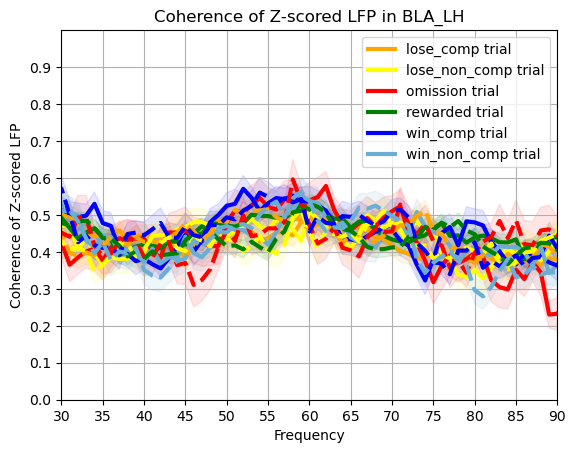

BLA_MD


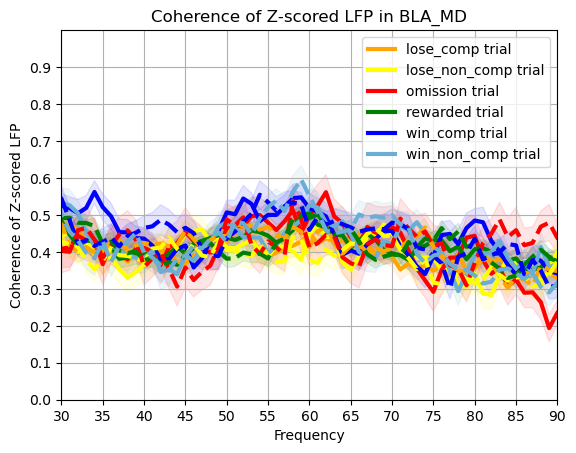

BLA_mPFC


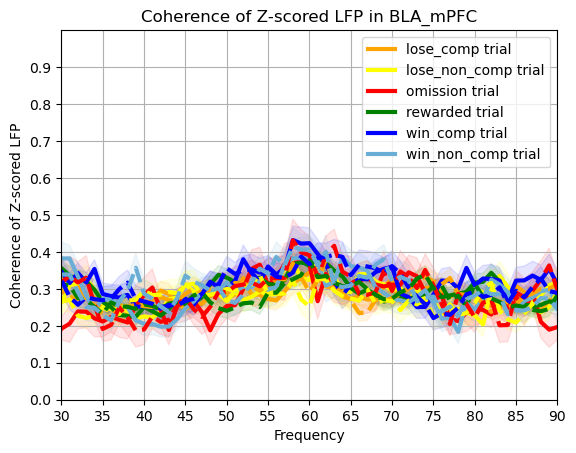

BLA_vHPC


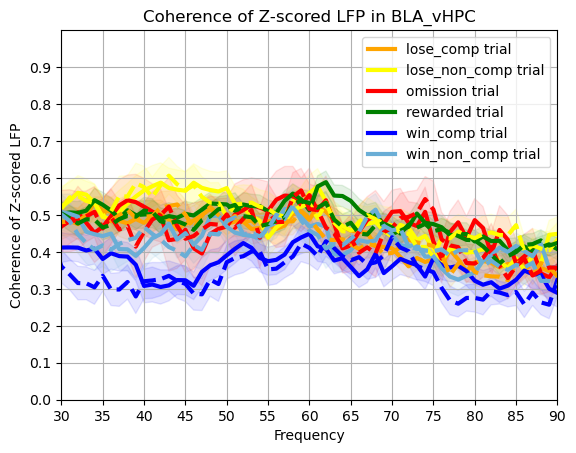

LH_MD


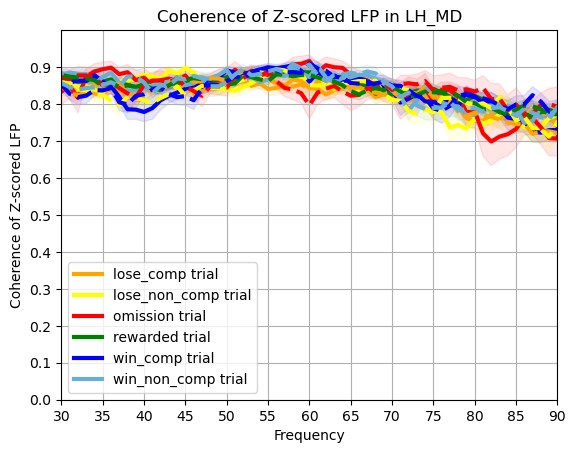

LH_mPFC


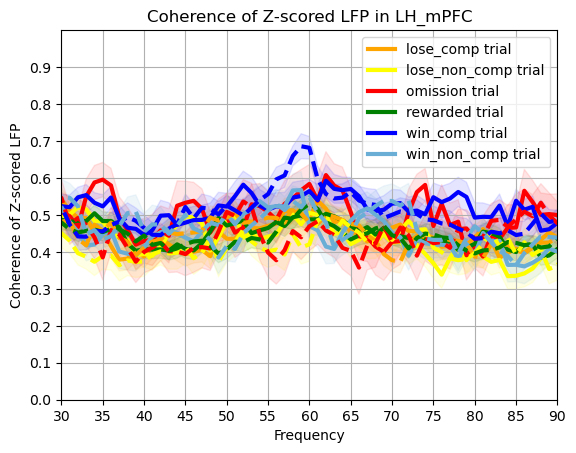

LH_vHPC


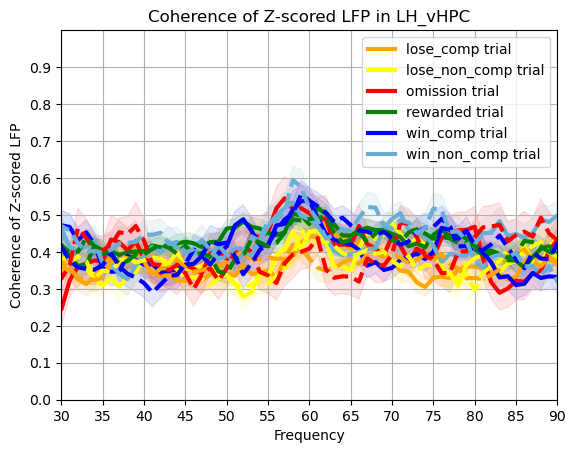

MD_mPFC


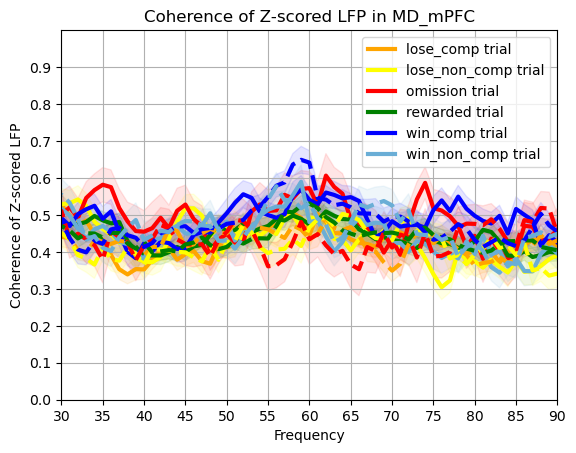

MD_vHPC


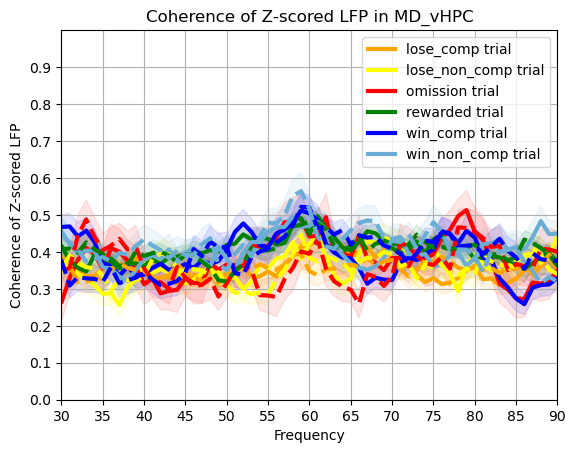

mPFC_vHPC


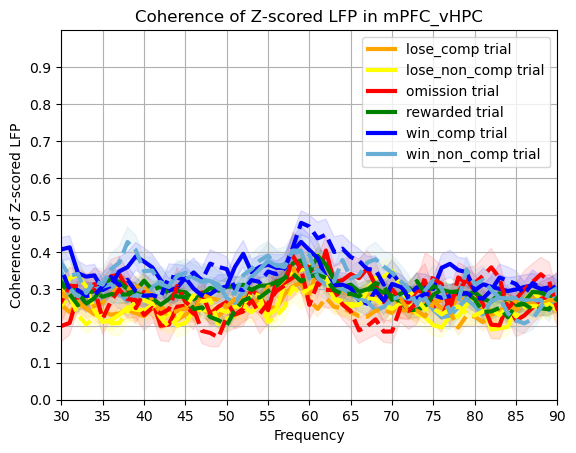

In [40]:
low_freq = 30
high_freq = 90

for pair_base_name in all_pair_base_name:
    print(pair_base_name)
    
    fig, ax = plt.subplots()
    plt.title("Coherence of Z-scored LFP in {}".format(pair_base_name))
    plt.xlabel("Frequency")
    plt.ylabel("Coherence of Z-scored LFP")
    plt.xlim(low_freq, high_freq)
    plt.xticks(np.arange(low_freq, high_freq+1, 5))
    plt.yticks(np.arange(0, 1, 0.1))
    plt.ylim(0,1)
    plt.grid()

    for trial_or_baseline in TRIAL_AND_BASELINE:

        coherence_col = "{}_{}_coherence_magnitude".format(pair_base_name, trial_or_baseline)
        grouped_all_trials_df = FULL_LFP_TRACES.groupby([GROUPINGS]).agg({coherence_col: lambda x: np.vstack(x.tolist())}).reset_index()
        # grouped_all_trials_df = grouped_all_trials_df[grouped_all_trials_df["trial_or_baseline"] == "trial"]
        grouped_all_trials_df["mean_coherence"] = grouped_all_trials_df[coherence_col].apply(lambda x: np.nanmean(np.vstack(x), axis=0))
        grouped_all_trials_df["std_coherence"] = grouped_all_trials_df[coherence_col].apply(lambda x: np.nanstd(np.vstack(x), axis=0))
        grouped_all_trials_df["n_trials"] = grouped_all_trials_df[coherence_col].apply(lambda x: np.sum(~np.isnan(x), axis=0))
        grouped_all_trials_df["sem_coherence"] = grouped_all_trials_df.apply(lambda x: x["std_coherence"] / np.sqrt(x["n_trials"]), axis=1)
        for index, row in grouped_all_trials_df.iterrows():
            try:
                if trial_or_baseline == "trial":
                    ax = sns.lineplot(x=all_frequencies, y=row["mean_coherence"], \
                label="{} {}".format(row[GROUPINGS], trial_or_baseline), color=BASELINE_OUTCOME_TO_COLOR[row[GROUPINGS]],
                linestyle=TRIAL_OR_BASELINE_TO_STYLE[trial_or_baseline], linewidth=3)
                else:
                    ax = sns.lineplot(x=all_frequencies, y=row["mean_coherence"], \
                color=BASELINE_OUTCOME_TO_COLOR[row[GROUPINGS]],
                linestyle=TRIAL_OR_BASELINE_TO_STYLE[trial_or_baseline], linewidth=3)
                

    
                plt.fill_between(all_frequencies, \
                row["mean_coherence"] - row["sem_coherence"], row["mean_coherence"] + row["sem_coherence"], alpha=0.1,
                color=BASELINE_OUTCOME_TO_COLOR[row[GROUPINGS]])
            except Exception as e: 
                print(e)


    
    # plt.savefig("./proc/coherence/{}_coherence_of_zscored_lfp.png".format(pair_base_name))
    plt.show()
    
    
    

    
    
    
    

    

In [41]:
def nested_dict():
    return defaultdict(dict)

In [42]:
all_frequencies[4:13]

array([ 4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.])

In [43]:
FREQUENCY_BANDS = (4,13)

In [44]:
BAND_TO_FREQUENCY = {"theta": (4,13), "beta": (12,31), "gamma": (30, 90)}

In [45]:
BAND_TO_ALL_COL = {"theta": [], "beta": [], "gamma": []}

In [46]:
all_coherence_col = [col for col in FULL_LFP_TRACES.columns if "trial_coherence_magnitude" in col]
for band, frequency in BAND_TO_FREQUENCY.items():
    for col in all_coherence_col:
        BAND_COL = "{}_averaged_{}_coherence".format(col.strip("_coherence_magnitude"), band)
        BAND_TO_ALL_COL[band].append(BAND_COL)
        print(BAND_COL)
        FULL_LFP_TRACES[BAND_COL] = FULL_LFP_TRACES[col].apply(lambda x: np.mean(x[frequency[0]:frequency[1]]))    


BLA_LH_trial_averaged_theta_coherence
BLA_MD_trial_averaged_theta_coherence
BLA_mPFC_trial_averaged_theta_coherence
BLA_vHPC_trial_averaged_theta_coherence
LH_MD_trial_averaged_theta_coherence
LH_mPFC_trial_averaged_theta_coherence
LH_vHPC_trial_averaged_theta_coherence
MD_mPFC_trial_averaged_theta_coherence
MD_vHPC_trial_averaged_theta_coherence
PFC_vHPC_trial_averaged_theta_coherence
BLA_LH_trial_averaged_beta_coherence
BLA_MD_trial_averaged_beta_coherence
BLA_mPFC_trial_averaged_beta_coherence
BLA_vHPC_trial_averaged_beta_coherence
LH_MD_trial_averaged_beta_coherence
LH_mPFC_trial_averaged_beta_coherence
LH_vHPC_trial_averaged_beta_coherence
MD_mPFC_trial_averaged_beta_coherence
MD_vHPC_trial_averaged_beta_coherence
PFC_vHPC_trial_averaged_beta_coherence
BLA_LH_trial_averaged_gamma_coherence
BLA_MD_trial_averaged_gamma_coherence
BLA_mPFC_trial_averaged_gamma_coherence
BLA_vHPC_trial_averaged_gamma_coherence
LH_MD_trial_averaged_gamma_coherence
LH_mPFC_trial_averaged_gamma_coherence


In [47]:
region_pair_to_outcome_to_coherence = {k: defaultdict(nested_dict) for k,v in BAND_TO_FREQUENCY.items()}

for band, frequency in BAND_TO_FREQUENCY.items():
    for outcome in FULL_LFP_TRACES[GROUPINGS].unique():
        outcome_df = FULL_LFP_TRACES[FULL_LFP_TRACES[GROUPINGS] == outcome].copy()
        for band_col in BAND_TO_ALL_COL[band]:
            band_col.strip("_averaged_{}_coherence".format(band))
            region_pair_to_outcome_to_coherence[band][band_col.strip("_averaged_{}_coherence".format(band))][outcome]["mean"] = outcome_df[band_col].mean() 
            region_pair_to_outcome_to_coherence[band][band_col.strip("_averaged_{}_coherence".format(band))][outcome]["std"] = outcome_df[band_col].sem() 




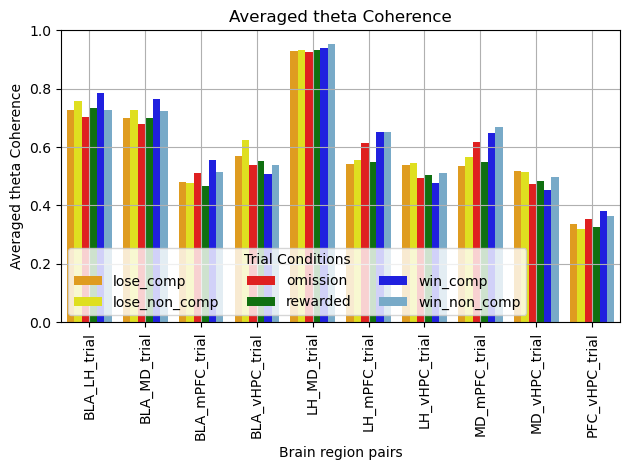

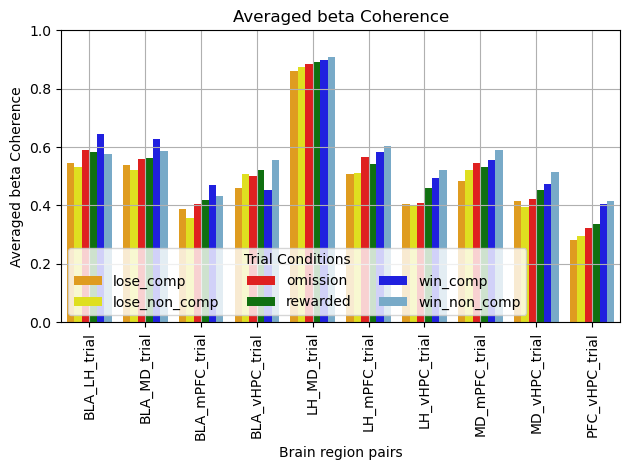

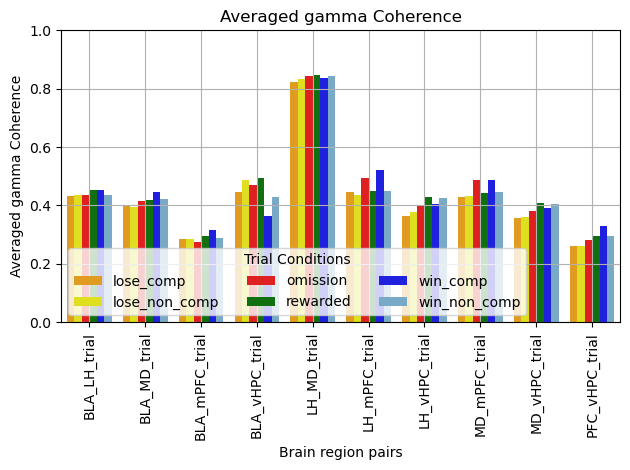

In [48]:
for band, frequency in BAND_TO_FREQUENCY.items(): 
    # Convert the nested dictionary to a DataFrame
    data = []
    for group_name, group_data in region_pair_to_outcome_to_coherence[band].items():
        for bar_name, bar_dict in group_data.items():
            data.append({"Group": group_name, "Bar": bar_name, "coherence": bar_dict["mean"], "std": bar_dict["std"]})
    df = pd.DataFrame(data).sort_values(by=["Group", "Bar"])
    df["color"] = df["Bar"].map(BASELINE_OUTCOME_TO_COLOR)
    
    # Create barplot
    ax = sns.barplot(x='Group', y='coherence', hue='Bar', data=df, palette=df["color"], ci=None)
    
    # Adding error bars
    groups = df['Group'].unique()
    bars_per_group = df['Bar'].nunique()
    bar_width = 0.8 / bars_per_group
    x_positions = []
    
    for i, group in enumerate(groups):
        num_bars = df[df['Group'] == group].shape[0]
        group_positions = np.linspace(i - bar_width*(num_bars-1)/2, i + bar_width*(num_bars-1)/2, num_bars)
        x_positions.extend(group_positions)
    
    plt.xticks(rotation=90)
    plt.xlabel("Brain region pairs")
    plt.ylabel("Averaged {} Coherence".format(band))
    plt.legend(title="Trial Conditions", loc="lower left", ncol=3)
    plt.title("Averaged {} Coherence".format(band))
    plt.tight_layout()
    plt.grid()
    plt.ylim(0,1)
    
    # plt.savefig("./proc/coherence/all_zscored_lfp_power_coherence.png")
    # Show the plot
    plt.show()

In [49]:
all_coherence_col = [col for col in FULL_LFP_TRACES.columns if "baseline_coherence_magnitude" in col]
for band, frequency in BAND_TO_FREQUENCY.items():
    for col in all_coherence_col:
        BAND_COL = "{}_averaged_{}_coherence".format(col.strip("_coherence_magnitude"), band)
        BAND_TO_ALL_COL[band].append(BAND_COL)
        print(BAND_COL)
        FULL_LFP_TRACES[BAND_COL] = FULL_LFP_TRACES[col].apply(lambda x: np.mean(x[frequency[0]:frequency[1]]))    


BLA_LH_basel_averaged_theta_coherence
BLA_MD_basel_averaged_theta_coherence
BLA_mPFC_basel_averaged_theta_coherence
BLA_vHPC_basel_averaged_theta_coherence
LH_MD_basel_averaged_theta_coherence
LH_mPFC_basel_averaged_theta_coherence
LH_vHPC_basel_averaged_theta_coherence
MD_mPFC_basel_averaged_theta_coherence
MD_vHPC_basel_averaged_theta_coherence
PFC_vHPC_basel_averaged_theta_coherence
BLA_LH_basel_averaged_beta_coherence
BLA_MD_basel_averaged_beta_coherence
BLA_mPFC_basel_averaged_beta_coherence
BLA_vHPC_basel_averaged_beta_coherence
LH_MD_basel_averaged_beta_coherence
LH_mPFC_basel_averaged_beta_coherence
LH_vHPC_basel_averaged_beta_coherence
MD_mPFC_basel_averaged_beta_coherence
MD_vHPC_basel_averaged_beta_coherence
PFC_vHPC_basel_averaged_beta_coherence
BLA_LH_basel_averaged_gamma_coherence
BLA_MD_basel_averaged_gamma_coherence
BLA_mPFC_basel_averaged_gamma_coherence
BLA_vHPC_basel_averaged_gamma_coherence
LH_MD_basel_averaged_gamma_coherence
LH_mPFC_basel_averaged_gamma_coherence


In [50]:
BAND_TO_ALL_COL

{'theta': ['BLA_LH_trial_averaged_theta_coherence',
  'BLA_MD_trial_averaged_theta_coherence',
  'BLA_mPFC_trial_averaged_theta_coherence',
  'BLA_vHPC_trial_averaged_theta_coherence',
  'LH_MD_trial_averaged_theta_coherence',
  'LH_mPFC_trial_averaged_theta_coherence',
  'LH_vHPC_trial_averaged_theta_coherence',
  'MD_mPFC_trial_averaged_theta_coherence',
  'MD_vHPC_trial_averaged_theta_coherence',
  'PFC_vHPC_trial_averaged_theta_coherence',
  'BLA_LH_basel_averaged_theta_coherence',
  'BLA_MD_basel_averaged_theta_coherence',
  'BLA_mPFC_basel_averaged_theta_coherence',
  'BLA_vHPC_basel_averaged_theta_coherence',
  'LH_MD_basel_averaged_theta_coherence',
  'LH_mPFC_basel_averaged_theta_coherence',
  'LH_vHPC_basel_averaged_theta_coherence',
  'MD_mPFC_basel_averaged_theta_coherence',
  'MD_vHPC_basel_averaged_theta_coherence',
  'PFC_vHPC_basel_averaged_theta_coherence'],
 'beta': ['BLA_LH_trial_averaged_beta_coherence',
  'BLA_MD_trial_averaged_beta_coherence',
  'BLA_mPFC_trial_av

In [51]:
region_pair_to_outcome_to_coherence = {k: defaultdict(nested_dict) for k,v in BAND_TO_FREQUENCY.items()}

for band, frequency in BAND_TO_FREQUENCY.items():
    for outcome in FULL_LFP_TRACES[GROUPINGS].unique():
        outcome_df = FULL_LFP_TRACES[FULL_LFP_TRACES[GROUPINGS] == outcome].copy()
        for band_col in BAND_TO_ALL_COL[band]:
            band_col.strip("_averaged_{}_coherence".format(band))
            region_pair_to_outcome_to_coherence[band][band_col.strip("_averaged_{}_coherence".format(band))][outcome]["mean"] = outcome_df[band_col].mean() 
            region_pair_to_outcome_to_coherence[band][band_col.strip("_averaged_{}_coherence".format(band))][outcome]["std"] = outcome_df[band_col].sem() 




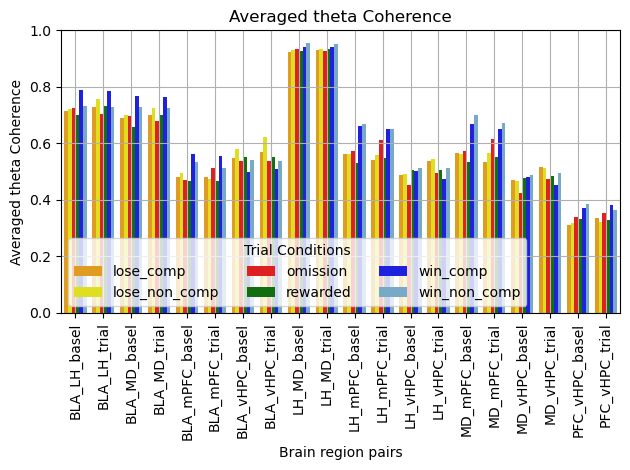

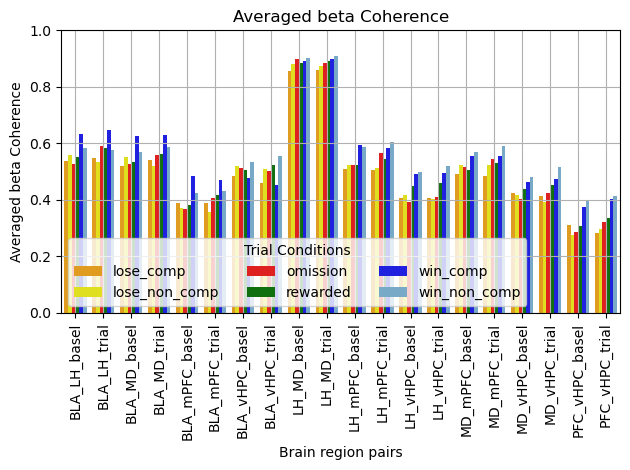

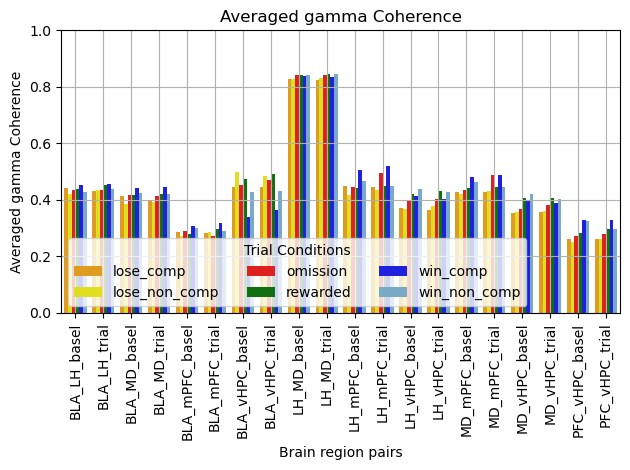

In [52]:
for band, frequency in BAND_TO_FREQUENCY.items(): 
    # Convert the nested dictionary to a DataFrame
    data = []
    for group_name, group_data in region_pair_to_outcome_to_coherence[band].items():
        for bar_name, bar_dict in group_data.items():
            data.append({"Group": group_name, "Bar": bar_name, "coherence": bar_dict["mean"], "std": bar_dict["std"]})
    df = pd.DataFrame(data).sort_values(by=["Group", "Bar"])
    df["color"] = df["Bar"].map(BASELINE_OUTCOME_TO_COLOR)
    
    # Create barplot
    ax = sns.barplot(x='Group', y='coherence', hue='Bar', data=df, palette=df["color"], ci=None)
    
    # Adding error bars
    groups = df['Group'].unique()
    bars_per_group = df['Bar'].nunique()
    bar_width = 0.8 / bars_per_group
    x_positions = []
    
    for i, group in enumerate(groups):
        num_bars = df[df['Group'] == group].shape[0]
        group_positions = np.linspace(i - bar_width*(num_bars-1)/2, i + bar_width*(num_bars-1)/2, num_bars)
        x_positions.extend(group_positions)
    
    plt.xticks(rotation=90)
    plt.xlabel("Brain region pairs")
    plt.ylabel("Averaged {} Coherence".format(band))
    plt.legend(title="Trial Conditions", loc="lower left", ncol=3)
    plt.title("Averaged {} Coherence".format(band))
    plt.tight_layout()
    plt.grid()
    plt.ylim(0,1)
    
    # plt.savefig("./proc/coherence/all_zscored_lfp_power_coherence.png")
    # Show the plot
    plt.show()

In [53]:
raise ValueError()

ValueError: 